In [114]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt


eng = matlab.engine.start_matlab()

print("matlab egine started")

matlab egine started


In [115]:
eng.addpath(f"C:\\Users\\madan\\FH11_RFML\\gui\\waveform_functions", nargout=0)



In [168]:
fs = 48e3
Tsymb = 1e-3
fc = 10e3
M = 64.0
Var = 1.0

sps = fs*Tsymb  
Nsymb = 2048

output_len = Nsymb*sps 

In [169]:
data = eng.mqam_gui(output_len, fs, Tsymb, fc, M)
data = np.array(data).flatten()

T = len(data)/fs

t = np.linspace(0,T,len(data))

(0.0, 0.0425)

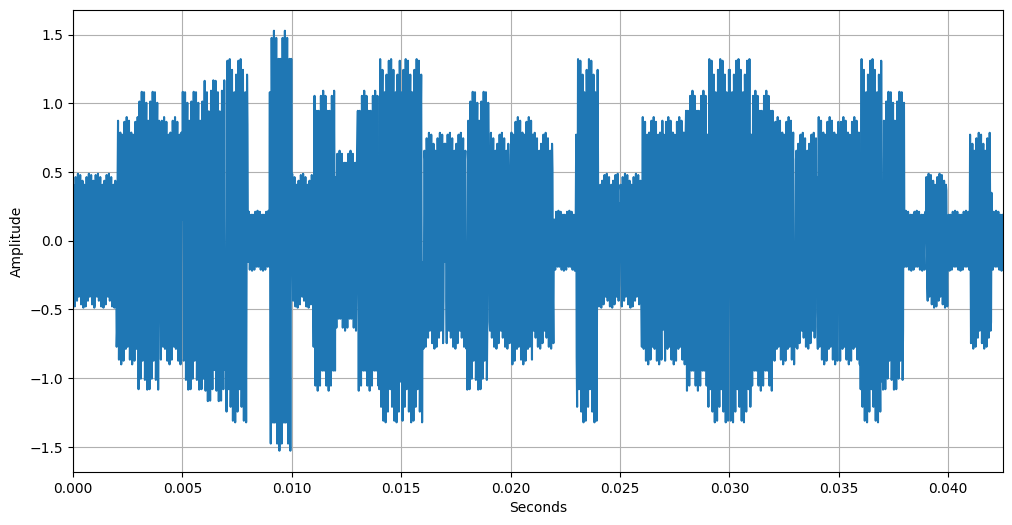

In [170]:
plt.figure(figsize=(12,6))
plt.plot(t,data)
plt.grid(True)
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.xlim([0,0.0425])

In [171]:
freqs, ft = eng.plotspec_gui(data, 1/fs, nargout = 2)
freqs = np.array(freqs).flatten()
ft = np.array(ft).flatten()

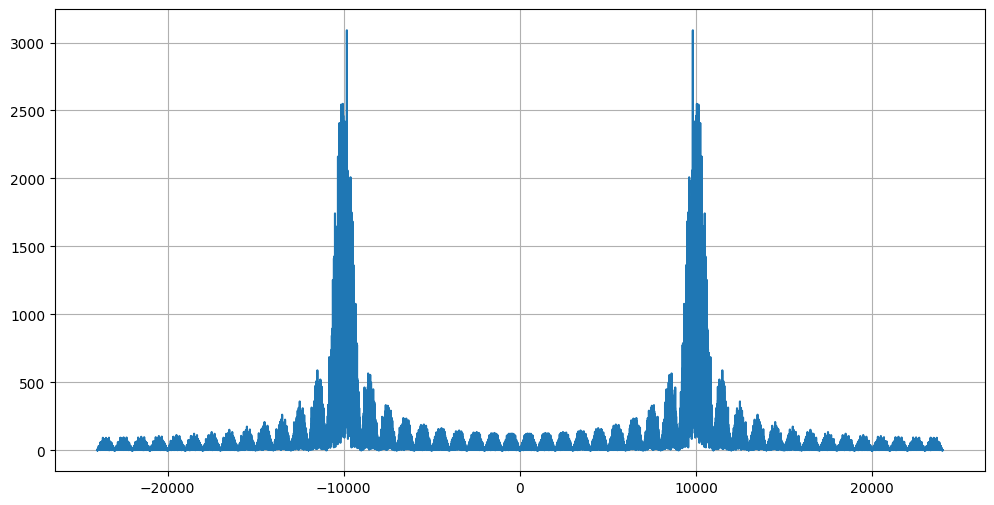

In [172]:
plt.figure(figsize=(12,6))
plt.plot(freqs, np.abs(ft))
plt.grid(True)

In [ ]:
# Better spectrum using Welch's method (reduces noise by averaging)
from scipy import signal

# Welch's method: averages multiple overlapping FFTs
f_welch, psd_welch = signal.welch(data, fs=fs, nperseg=4096, noverlap=2048, nfft=8192)

plt.figure(figsize=(12,6))
plt.plot(f_welch/1e3, 10*np.log10(psd_welch))  # Convert to dB and kHz
plt.grid(True, alpha=0.3)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title('Improved Spectrum (Welch Method)')
plt.xlim([0, fs/2/1e3])  # Show only positive frequencies


In [ ]:
# Spectrogram - shows frequency content over time
f_spec, t_spec, Sxx = signal.spectrogram(data, fs=fs, nperseg=512, noverlap=256, nfft=2048)

plt.figure(figsize=(12,6))
plt.pcolormesh(t_spec, f_spec/1e3, 10*np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram - Frequency vs Time')
plt.ylim([0, 20])  # Focus on 0-20 kHz range where signal is


(-1.1883985002458668,
 1.1883775610953773,
 -1.1882417423307965,
 1.1882467262516272)

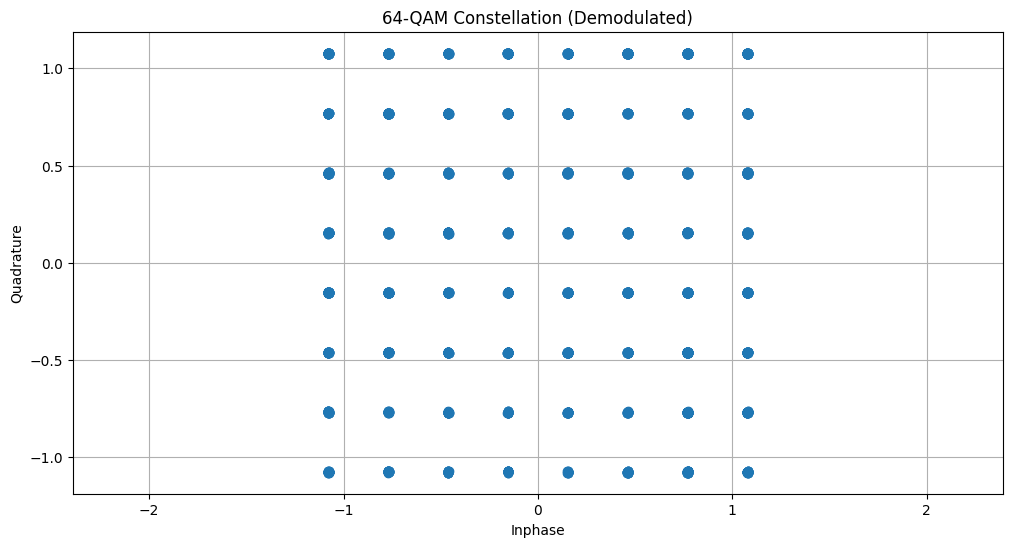

In [173]:
from scipy import signal

plt.figure(figsize=(12,6))

# Proper I/Q demodulation
t_demod = np.arange(len(data)) / fs

# Demodulate I (in-phase) and Q (quadrature) components
I = data * 2 * np.cos(2*np.pi*fc*t_demod)
Q = data * (-2) * np.sin(2*np.pi*fc*t_demod)

# Low-pass filter to remove high-frequency components (2*fc)
# Design a low-pass filter with cutoff at fc/2
sos = signal.butter(4, fc/2, 'low', fs=fs, output='sos')
I_filtered = signal.sosfilt(sos, I)
Q_filtered = signal.sosfilt(sos, Q)

# Downsample to symbol rate (one sample per symbol)
# Take samples at the middle of each symbol period for best sampling point
offset = int(sps/2)  # Sample at center of symbol
I_symbols = I_filtered[offset::int(sps)]
Q_symbols = Q_filtered[offset::int(sps)]

plt.scatter(I_symbols, Q_symbols)
plt.grid(True)
plt.xlabel("Inphase")
plt.ylabel("Quadrature")
plt.title(f"{int(M)}-QAM Constellation (Demodulated)")
plt.axis('equal')
